In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import qmc
from utils import *
from pinn import PINNs
# import deepxde as dde

/home/mukul/miniconda3/envs/PF/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
model = PINNs(in_dim=2, hidden_dim=256, out_dim=1, num_layer=6)
n_params = get_n_params(model)
print(n_params)

264193


In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cpu'

In [4]:
# BS params
K = 4
sigma = 0.3
r = 0.03
T = 1
L = 10
N_x = 101
N_t = 101

In [5]:
res, b_left, b_right, b_upper, b_lower = get_data([0,10], [0, 1], N_x, N_t)
res_test, _, _, _, _ = get_data([0,10], [0,1], N_x, N_t)
print(res.shape, b_left.shape, b_right.shape, b_upper.shape, b_lower.shape)
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)

(10000, 2) (101, 2) (101, 2) (101, 2) (101, 2)
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])


In [19]:
x_left, t_left
x_right, t_right

# res, b_left, b_right, b_upper, b_lower = get_data([0,10], [0, 1], N_x, N_t)
# res_test, _, _, _, _ = get_data([0,10], [0,1], N_x, N_t)
# print(res.shape, b_left.shape, b_right.shape, b_upper.shape, b_lower.shape)
# res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
# b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
# b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
# b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
# b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
# x_res, t_res = res[:,0:1], res[:,1:2]
# x_left, t_left = b_left[:,0:1], b_left[:,1:2]
# x_right, t_right = b_right[:,0:1], b_right[:,1:2]
# x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
# x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

# print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
# print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)

(tensor([[ 0.0000],
         [ 0.1010],
         [ 0.2020],
         [ 0.3030],
         [ 0.4040],
         [ 0.5051],
         [ 0.6061],
         [ 0.7071],
         [ 0.8081],
         [ 0.9091],
         [ 1.0101],
         [ 1.1111],
         [ 1.2121],
         [ 1.3131],
         [ 1.4141],
         [ 1.5152],
         [ 1.6162],
         [ 1.7172],
         [ 1.8182],
         [ 1.9192],
         [ 2.0202],
         [ 2.1212],
         [ 2.2222],
         [ 2.3232],
         [ 2.4242],
         [ 2.5253],
         [ 2.6263],
         [ 2.7273],
         [ 2.8283],
         [ 2.9293],
         [ 3.0303],
         [ 3.1313],
         [ 3.2323],
         [ 3.3333],
         [ 3.4343],
         [ 3.5354],
         [ 3.6364],
         [ 3.7374],
         [ 3.8384],
         [ 3.9394],
         [ 4.0404],
         [ 4.1414],
         [ 4.2424],
         [ 4.3434],
         [ 4.4444],
         [ 4.5455],
         [ 4.6465],
         [ 4.7475],
         [ 4.8485],
         [ 4.9495],


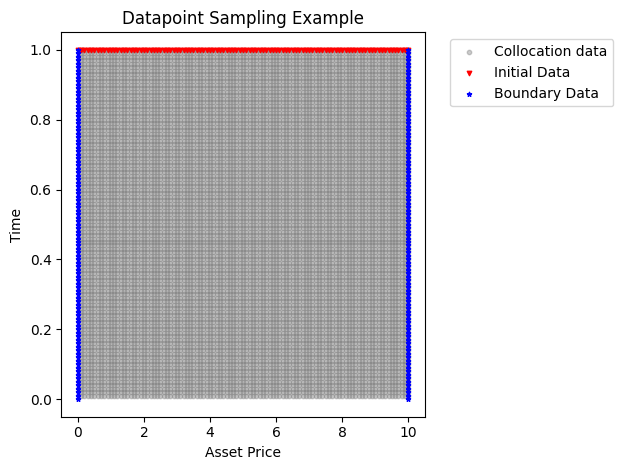

In [16]:
# plt.figure(figsize=(4,3))
plt.scatter(x_res.cpu().detach().numpy(), t_res.cpu().detach().numpy(), marker='o', color='gray', s=10, alpha=0.4, label='Collocation data')
# plt.scatter(x_left.cpu().detach().numpy(), t_left.cpu().detach().numpy(), color='black', s=10, label='Left Boundary Value')
plt.scatter(x_right.cpu().detach().numpy(), t_right.cpu().detach().numpy(), marker='v', color='red', s=10, label='Initial Data')
plt.scatter(x_upper.cpu().detach().numpy(), t_upper.cpu().detach().numpy(), marker='*', color='blue', s=10, label='Boundary Data')
plt.scatter(x_lower.cpu().detach().numpy(), t_lower.cpu().detach().numpy(), marker='*', color='blue', s=10)

plt.xlabel('Asset Price')
plt.ylabel('Time')
plt.title('Datapoint Sampling Example')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
# plt.savefig('datapoint_sampling_fig')
plt.show()

In [21]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [22]:
model = PINNs(in_dim=2, hidden_dim=20, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = Adam(model.parameters(), lr=0.001)

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

/tmp/ipykernel_1932120/239054705.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
921


In [23]:
loss_track = []
n_epochs = 10

for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = model(x_res, t_res)
    pred_left = model(x_left, t_left)
    pred_right = model(x_right, t_right)
    pred_upper = model(x_upper, t_upper)
    pred_lower = model(x_lower, t_lower)

    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)

    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim.zero_grad()
    loss.backward()
    return loss

  optim.step(closure)
  if i % 10 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.5f}, BVP Loss: {loss_track[-1][1]:.5f}, IC Loss: {loss_track[-1][2]:.5f},')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 15.15it/s]

0/10 PDE Loss: 0.01555, BVP Loss: 2.17983, IC Loss: 16.30608,


In [10]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.453174, Loss_BC: 0.153905, Loss_IC: 0.301715
Train Loss: 0.908794


## Using LBFGS for further training

In [11]:
optim2 = LBFGS(model.parameters())
n_params = get_n_params(model)

print(model)
print(get_n_params(model))

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
921


In [12]:
lbfgs_loss_track = []
n_epochs = 150

for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = model(x_res, t_res)
    pred_left = model(x_left, t_left)
    pred_right = model(x_right, t_right)
    pred_upper = model(x_upper, t_upper)
    pred_lower = model(x_lower, t_lower)

    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)

    lbfgs_loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim2.zero_grad()
    loss.backward()
    return loss

  optim2.step(closure)
  if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {lbfgs_loss_track[-1][0]:.5f}, BVP Loss: {lbfgs_loss_track[-1][1]:.5f}, IC Loss: {lbfgs_loss_track[-1][2]:.5f},')

  1%|          | 1/150 [00:00<01:07,  2.21it/s]

0/150 PDE Loss: 0.00225, BVP Loss: 0.01055, IC Loss: 0.00074,


 67%|██████▋   | 101/150 [00:45<00:24,  2.00it/s]

100/150 PDE Loss: 0.00003, BVP Loss: 0.00006, IC Loss: 0.00000,


100%|██████████| 150/150 [01:07<00:00,  2.23it/s]


In [13]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(lbfgs_loss_track[-1][0], lbfgs_loss_track[-1][1], lbfgs_loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(lbfgs_loss_track[-1])))

Loss Res: 0.000024, Loss_BC: 0.000027, Loss_IC: 0.000000
Train Loss: 0.000050
